# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from PIL import Image # converting images into arrays

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# install wordcloud
#!pip install wordcloud 
import lightgbm as lgb

# import PyTorch and transformers libraries
import torch
import transformers

# import package and its set of stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# import metrics
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve

# import machine learning models
from sklearn.dummy import DummyClassifier # dummy classifier
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.naive_bayes import MultinomialNB # naive bayes classifier
from lightgbm import LGBMClassifier # lightGBM classifier
from sklearn.svm import SVC # svc classifier

import sys
import warnings # ignore warnings
warnings.filterwarnings("ignore")

print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Conclusion**

We loaded the data and observe that the dataset consists of 47331 rows and 17 columns. The `review` column contains 47331 entries with a datatype *object*. The `pos` column contains 47331 entries with a datatype *int64*. We proceed to carry out exploratory data analysis on the dataset.

## EDA

Let's check the number of movies and reviews over years.

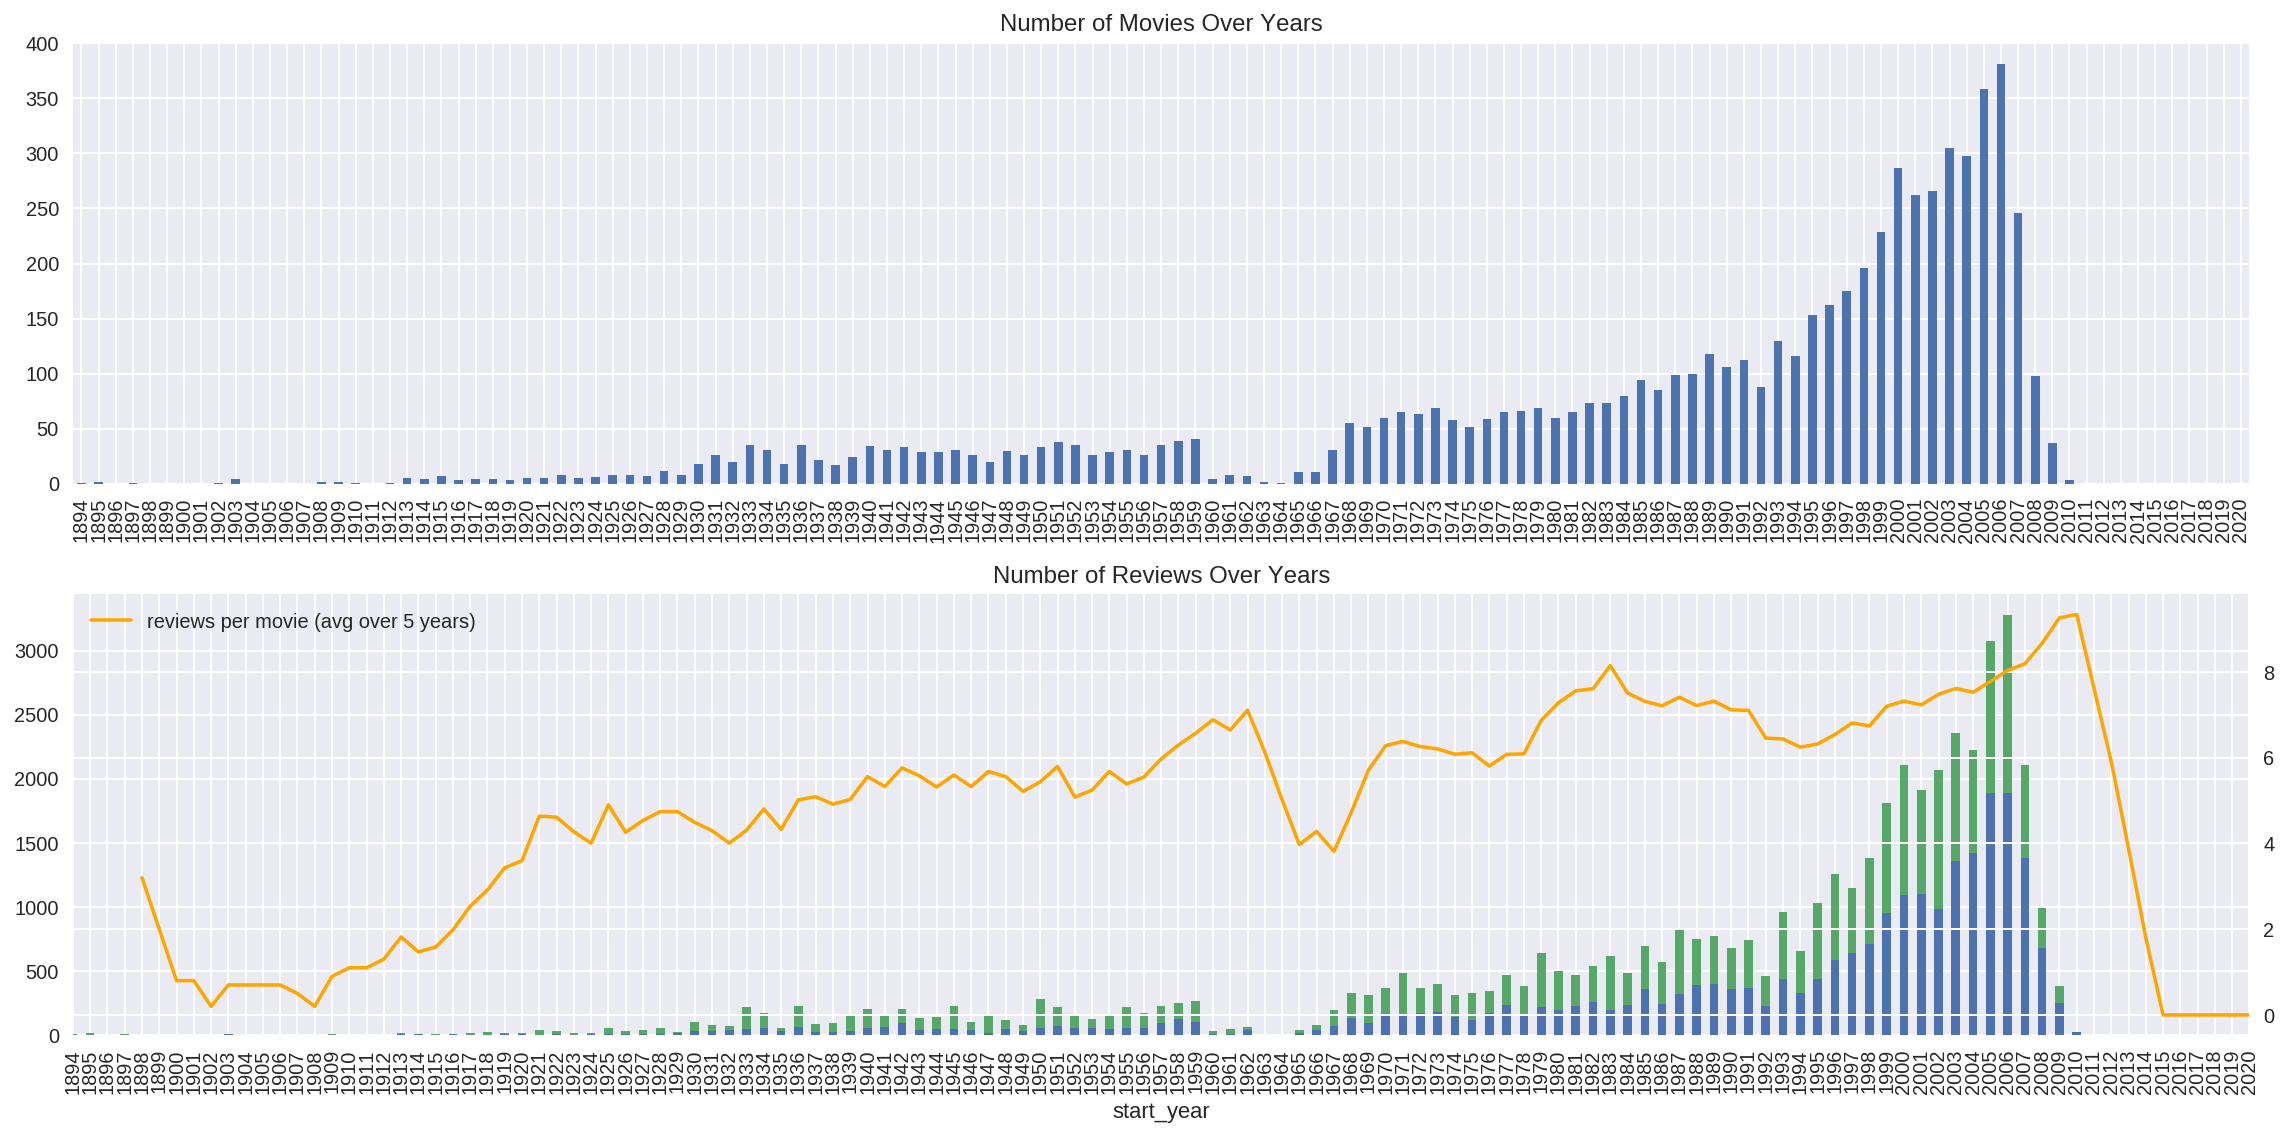

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that historically over the years, the number of movies increases up until 2007. Consequently, the reviews per movie is between 250 and 3250 reviews. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

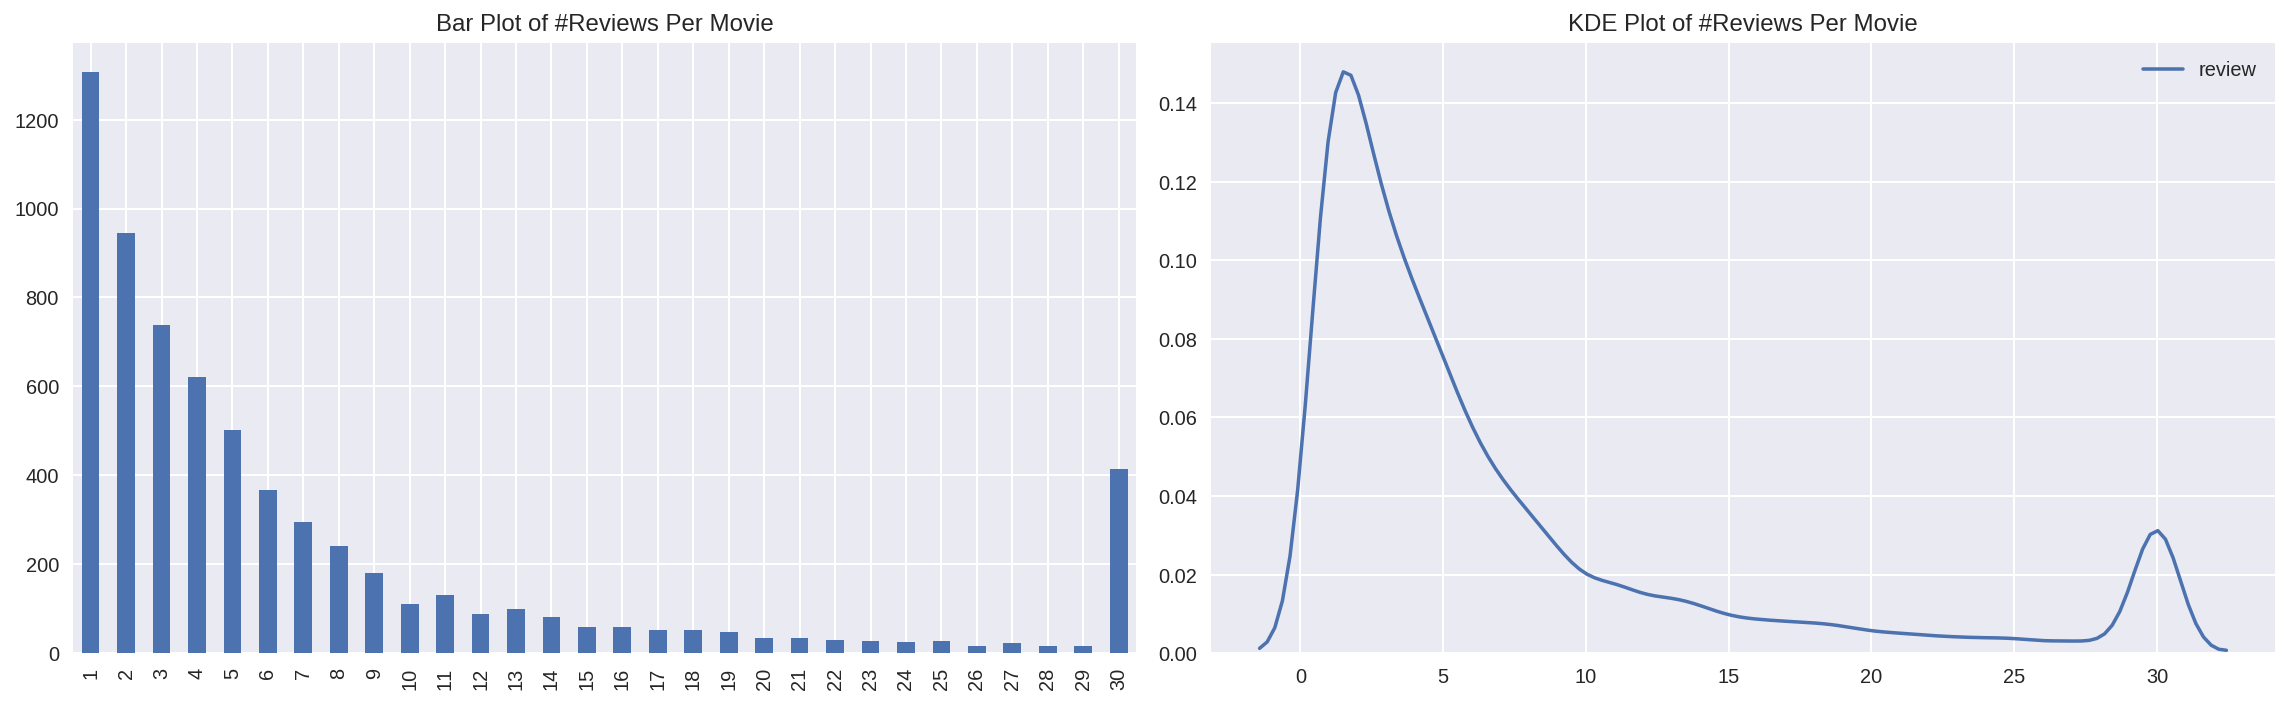

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The `pos` column contains class labels for each review. If the label is 0, then it is a negative review. If it is 1, then it is a positive review. Let's visualize and plot the distribution for the number of occurences of each label using a pie chart.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

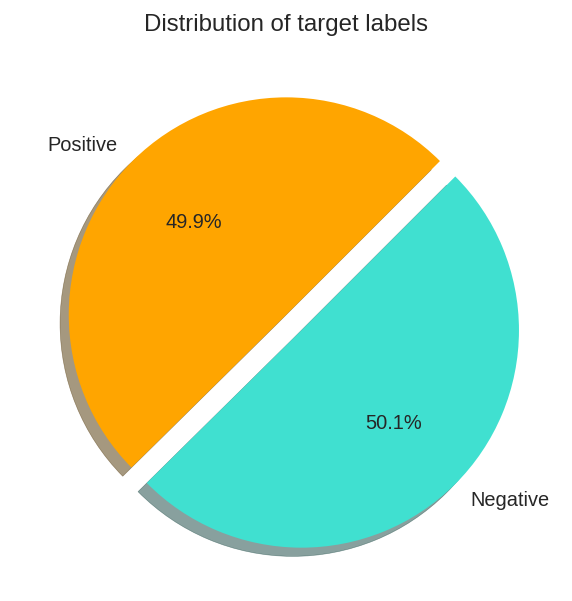

In [11]:
# plotting the pie chart
fig = plt.figure(figsize=(5,5))
colors = ['orange', 'turquoise']
pos_ = df_reviews[df_reviews['pos'] == 1]
neg_ = df_reviews[df_reviews['pos'] == 0]
count = [pos_['pos'].count(), neg_['pos'].count()]
plt.pie(count, labels=['Positive', 'Negative'],
        autopct ='%1.1f%%',
        shadow = True,
        colors = colors,
        startangle = 45,
        explode=(0, 0.1))
plt.title('Distribution of target labels')
plt.show()

From the pie chart, we can see that the labels are almost equally distributed between the two classes. There are 23616 positive reviews and 23715 negative reviews.

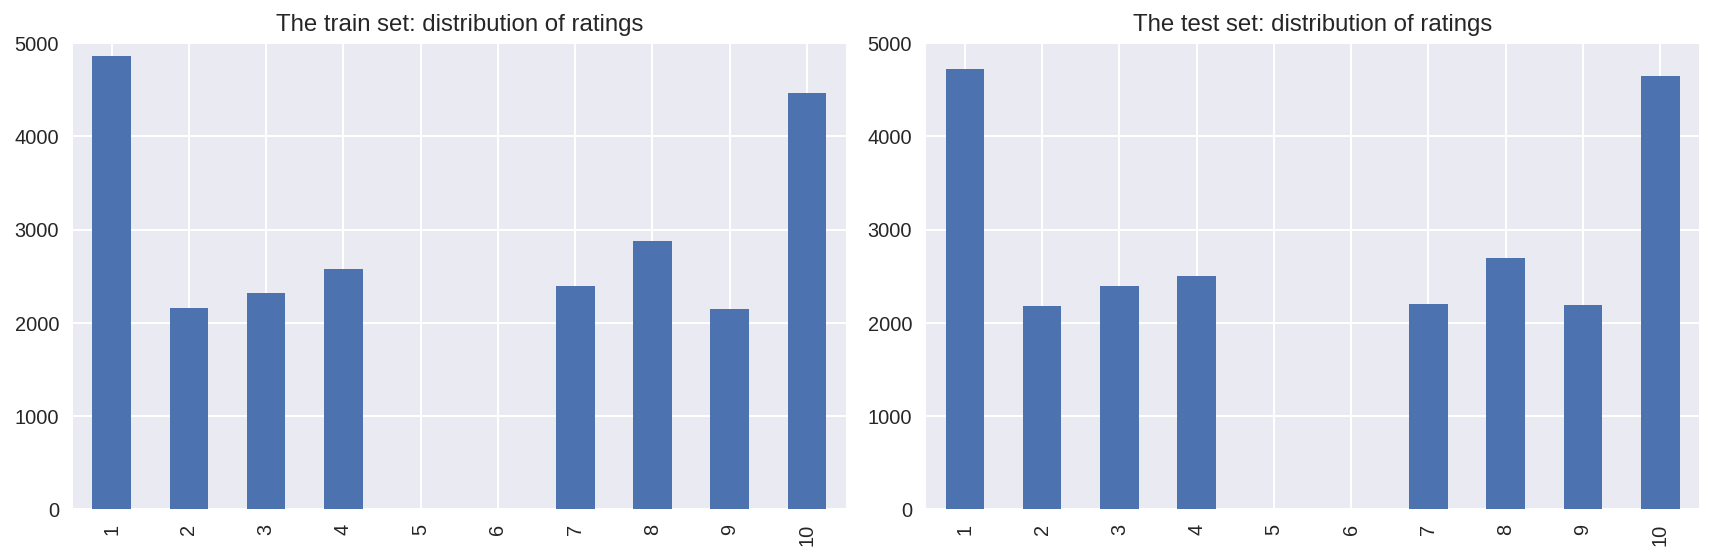

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The train and the test data sets have approximately the same distribution of ratings. We can visaulize the distribution of negative and positive reviews over the years.

Distribution of negative and positive reviews over the years for two parts of the dataset

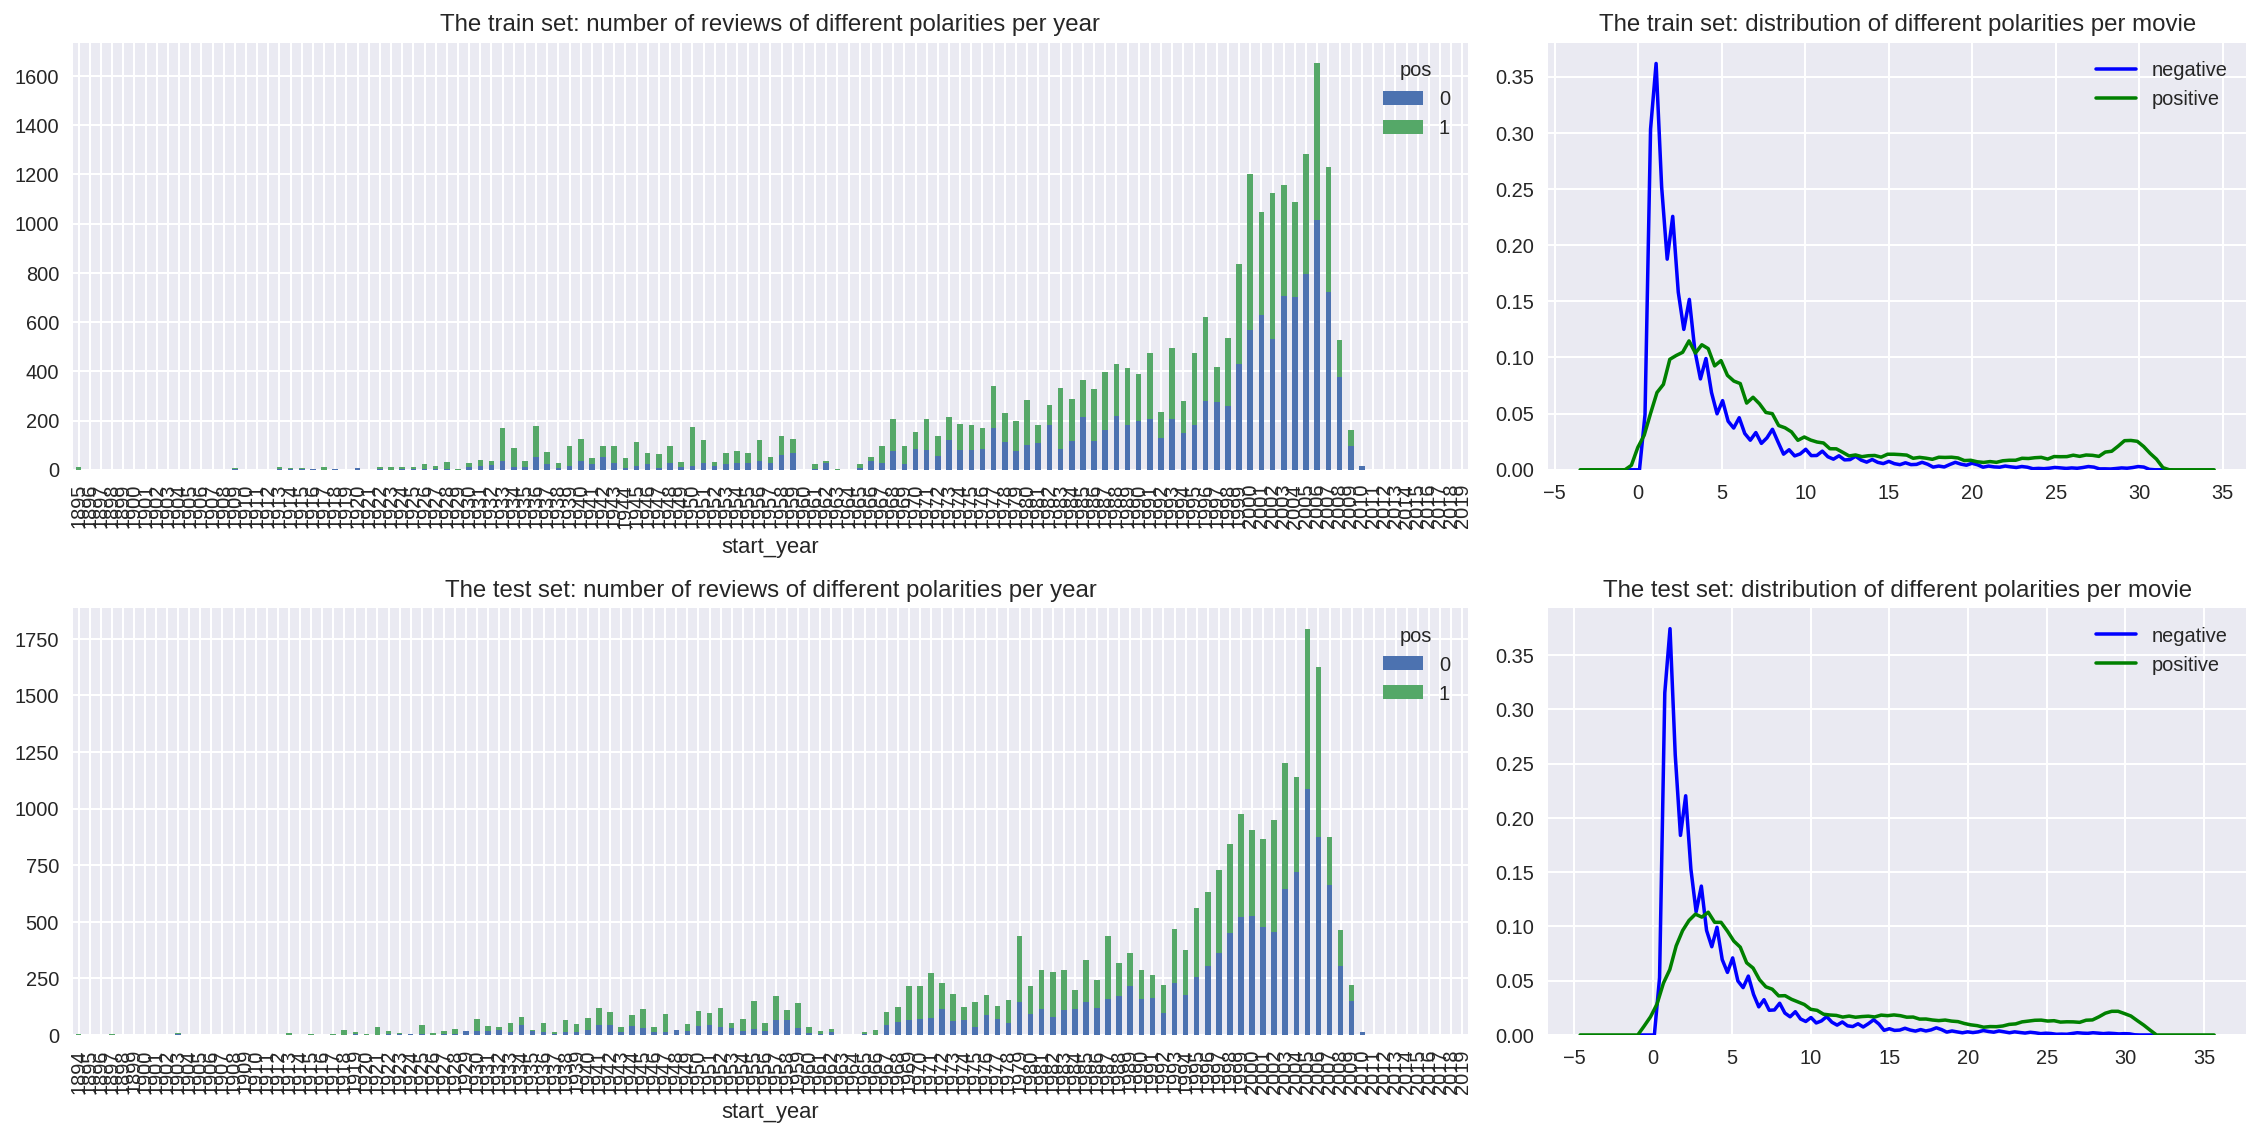

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Word cloud is an interesting way to visualize popular words based on frequency of the words. Let's create two word clouds, one for positive movie reviews and one for negative reviews.

In [14]:
# function to clean the data
def clean_data(data):
    ''' 
    this function is used to clean 
    the data of non standard characters
    '''
    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

In [15]:
df_reviews['review'] = df_reviews['review'].apply(clean_data)
df_reviews['review'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review, dtype: object

In [16]:
# filter positive and negative reviews
positive_reviews = df_reviews[df_reviews['pos'] == 1]
positive_reviews = positive_reviews.review

negative_reviews = df_reviews[df_reviews['pos'] == 0]
negative_reviews = negative_reviews.review

In [17]:
# function to create word clouds for reviews
def wordcloud(data, mask_image):
    '''
    this function instantiates a word cloud
    object and generates the word cloud
    '''
    stop_words = stopwords.words("english")
    words = " ".join(data)
    # removing unmeaningful words
    for word_to_remove in ['character', 'even', 'one', 'see', 'get', 'show', 'like', 'way',
                           'would', 'well', 'scene', 'story', 'good', 'make', 'also', 'time']:
        if word_to_remove in positive_reviews:
            stop_words = stop_words
        else:
            stop_words.append(word_to_remove)
    # clean words        
    cleaned_word = " ".join([word for word in words.split()
                             if (word != 'movie' and word != 'film' 
                                 and word not in stop_words)
                            ])
    # instantiate a word cloud
    movie_wc = WordCloud(
        background_color='white',
        mask = mask_image,
        stopwords = stop_words,
        contour_width=3, 
        contour_color='steelblue'
    ).generate(cleaned_word) # generate word cloud
    # display the word cloud
    fig = plt.figure(figsize=[12,12])
    plt.imshow(movie_wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [18]:
import urllib.request

urllib.request.urlretrieve('https://chuksooismywebsitebucket.s3.us-west-2.amazonaws.com/alice_mask.png')

# save mask to alice_mask 
alice_mask = np.array(Image.open('alice_mask.png'))

Positive words


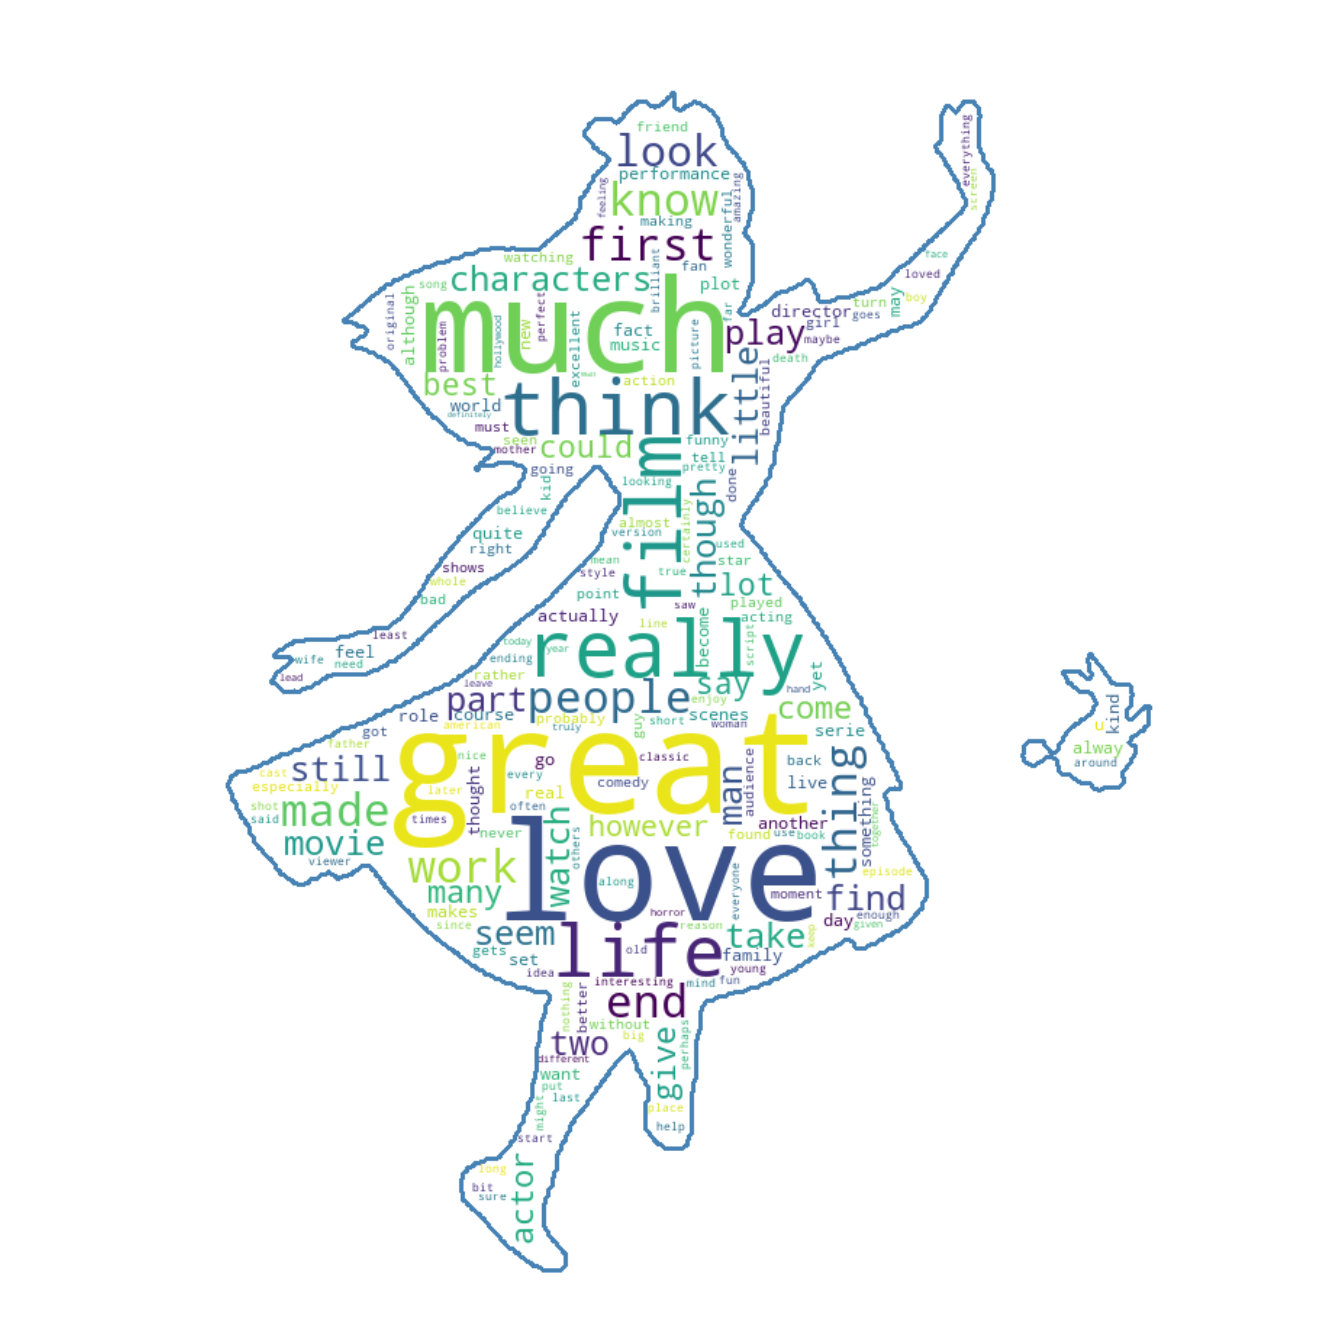

In [19]:
print('Positive words')
wordcloud(positive_reviews, alice_mask)

Negative Words


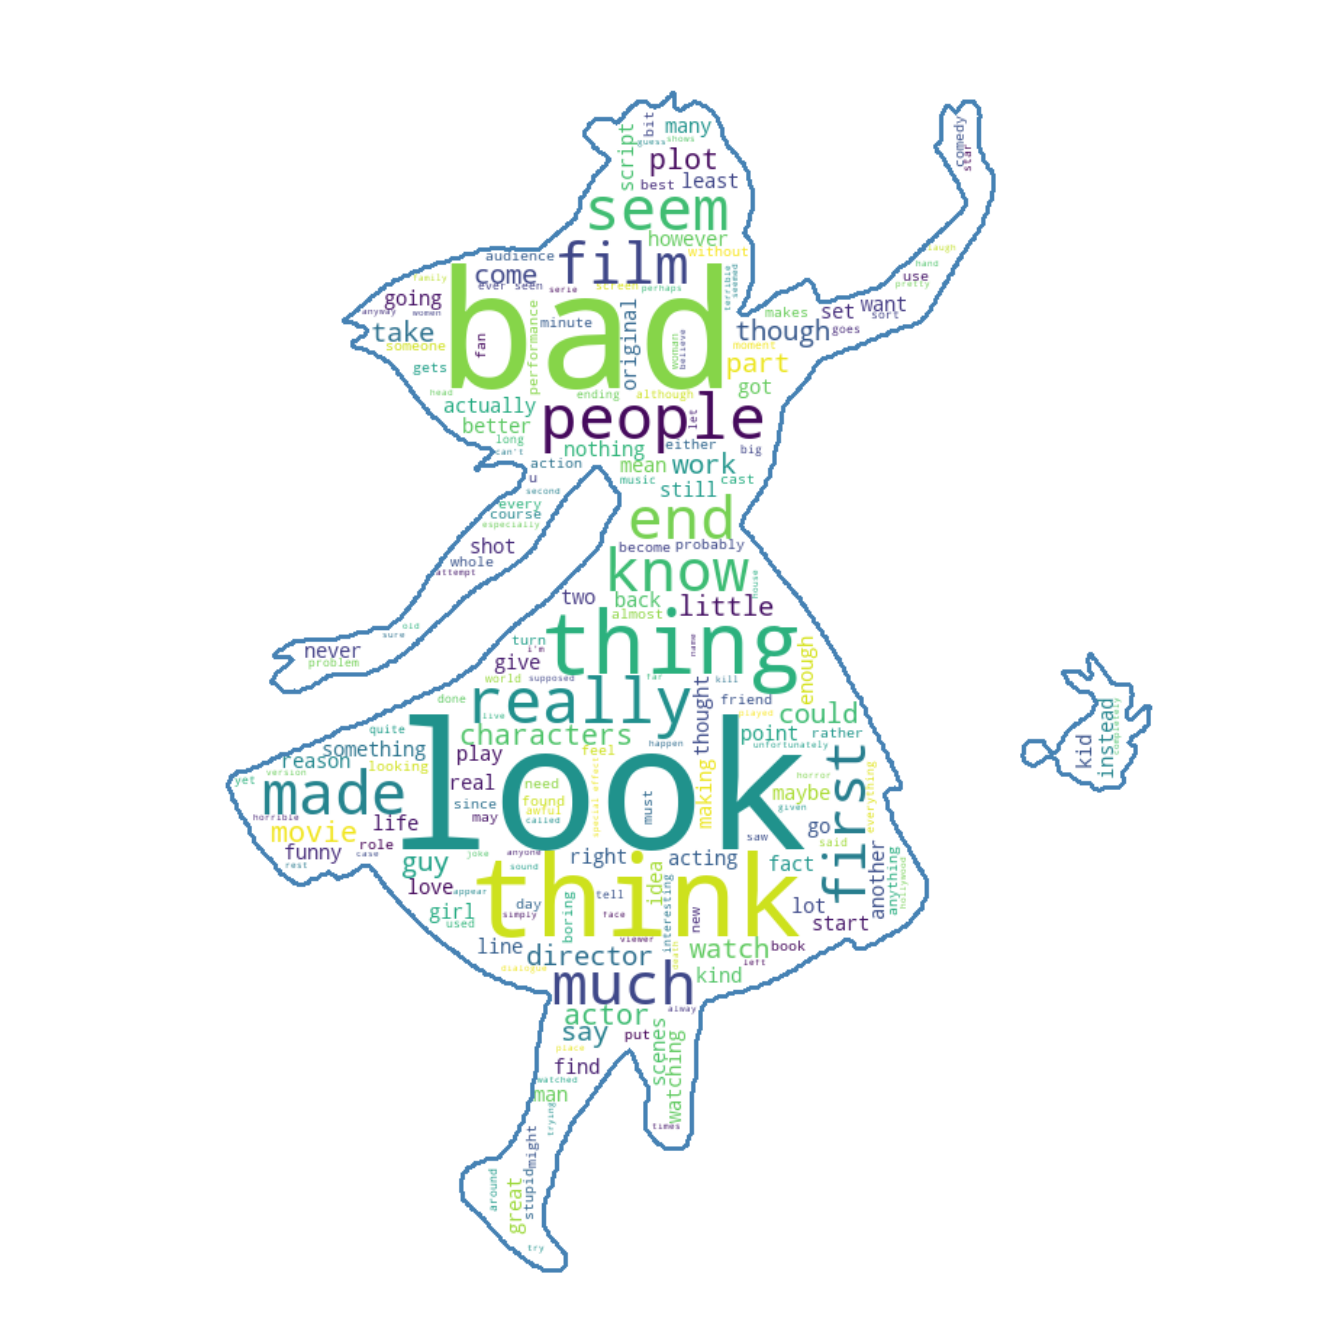

In [20]:
print('Negative Words')
wordcloud(negative_reviews, alice_mask)

**Conclusion**

We cleaned the data and then proceeded to plot the word cloud for both negative and positive reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [21]:
# function to evaluate classification models
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_data)
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

We would use four different machine learning methods such as Naïve Bayes, LGBMClassifier, Logistic Regression and Support Vector Machines (SVM) for our sentiment analysis and try out different text preprocessing techniques with the same four models. Our goal is to check how different preprocessing techniques affect the performance of our models.

### Model 0 - Constant

In [24]:
%%time
# dummy classifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

CPU times: user 2.18 ms, sys: 0 ns, total: 2.18 ms
Wall time: 1.31 ms


DummyClassifier(constant=None, random_state=None, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


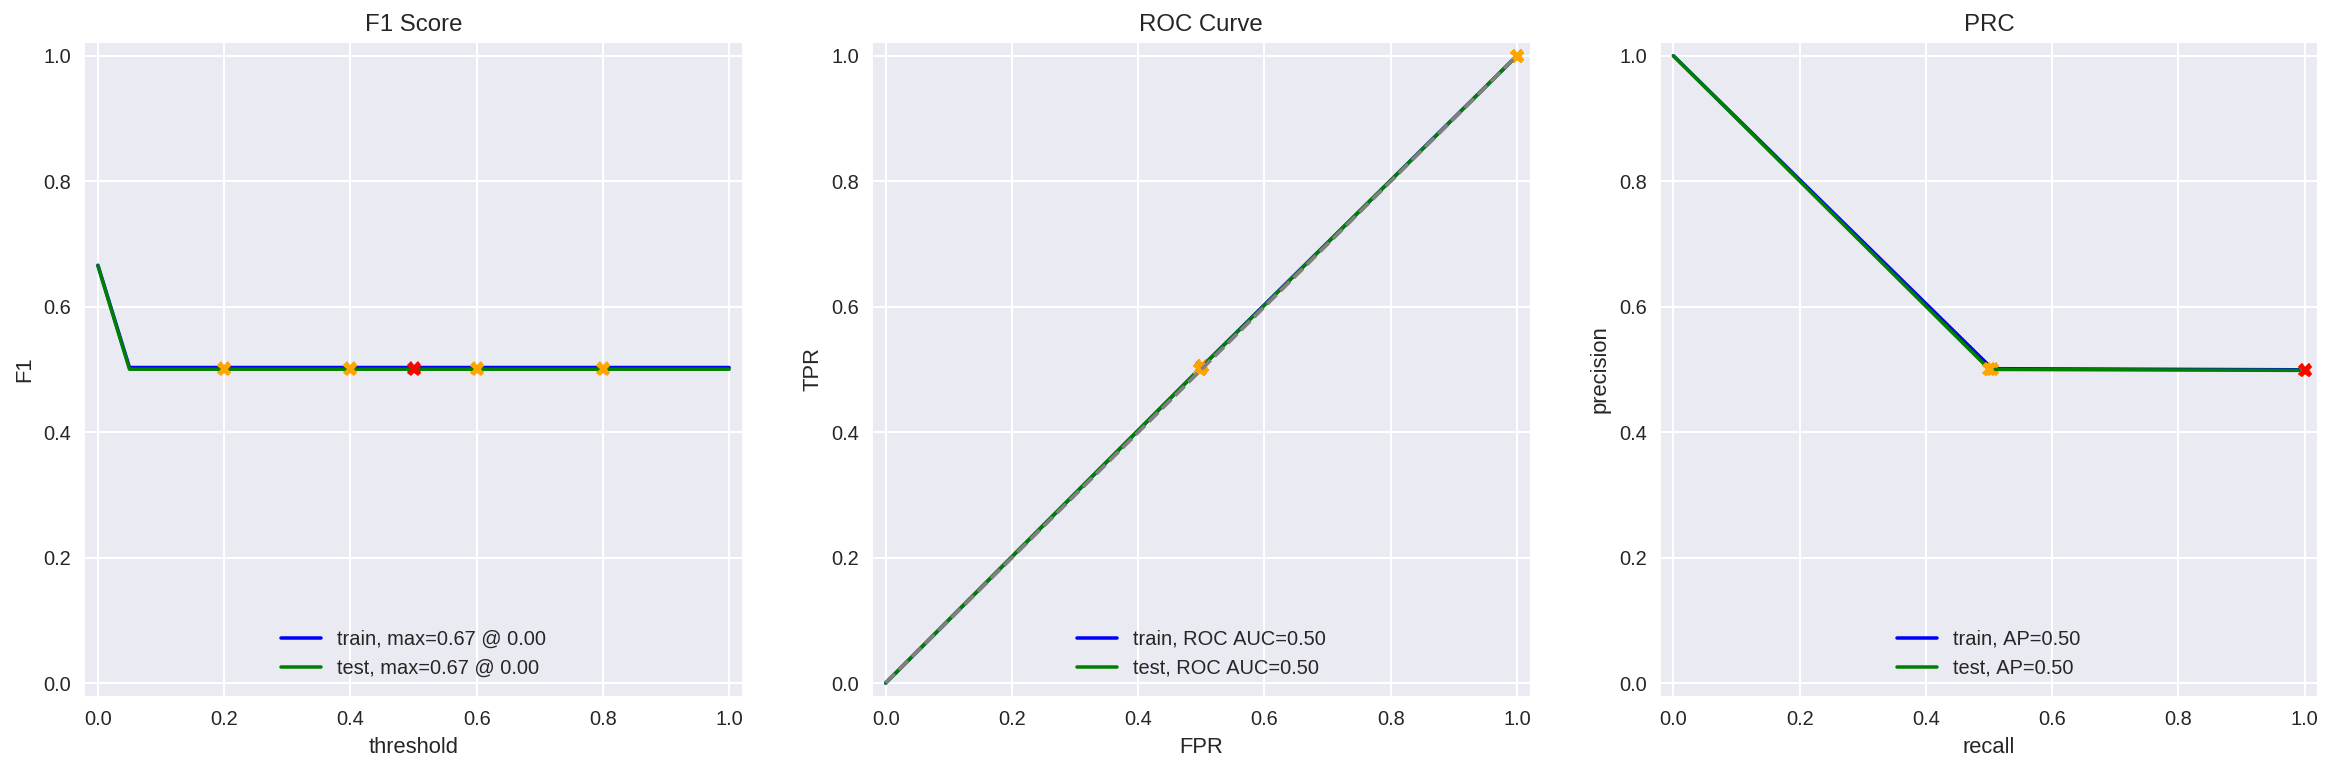

In [25]:
# evaluate dummy model
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

From the dummy classifier, we obtained an accuracy of 50% and an FI score of o.5. This model serves as the baseline model in this project. 

### Preprocessing with NLTK and TF-IDF

TF-IDF

In [26]:
# text pre-processing with NLTK
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) # create a counter

# function to tokenize and lemmatize text using NLTK
def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer() # create a lemmatization object
    tokens = word_tokenize(text.lower()) # split text into tokens
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized = " ".join(lemmas) 
    return lemmatized

In [27]:
# apply lemmatization to features
df_reviews_train['review_nltk'] = X_train.apply(lemmatize_nltk)
df_reviews_test['review_nltk'] = X_test.apply(lemmatize_nltk)

# recalculate TF-IDF for train and test samples
nltk_X_train = count_tf_idf.fit_transform(df_reviews_train['review_nltk'])
nltk_X_test = count_tf_idf.transform(df_reviews_test['review_nltk'])

#### Naïve Bayes Classifier with NLTK

In [28]:
%%time
# train naïve bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(nltk_X_train, y_train)

CPU times: user 21.4 ms, sys: 46 µs, total: 21.5 ms
Wall time: 20.2 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

          train  test
Accuracy   0.91  0.83
F1         0.91  0.82
APS        0.97  0.91
ROC AUC    0.97  0.91


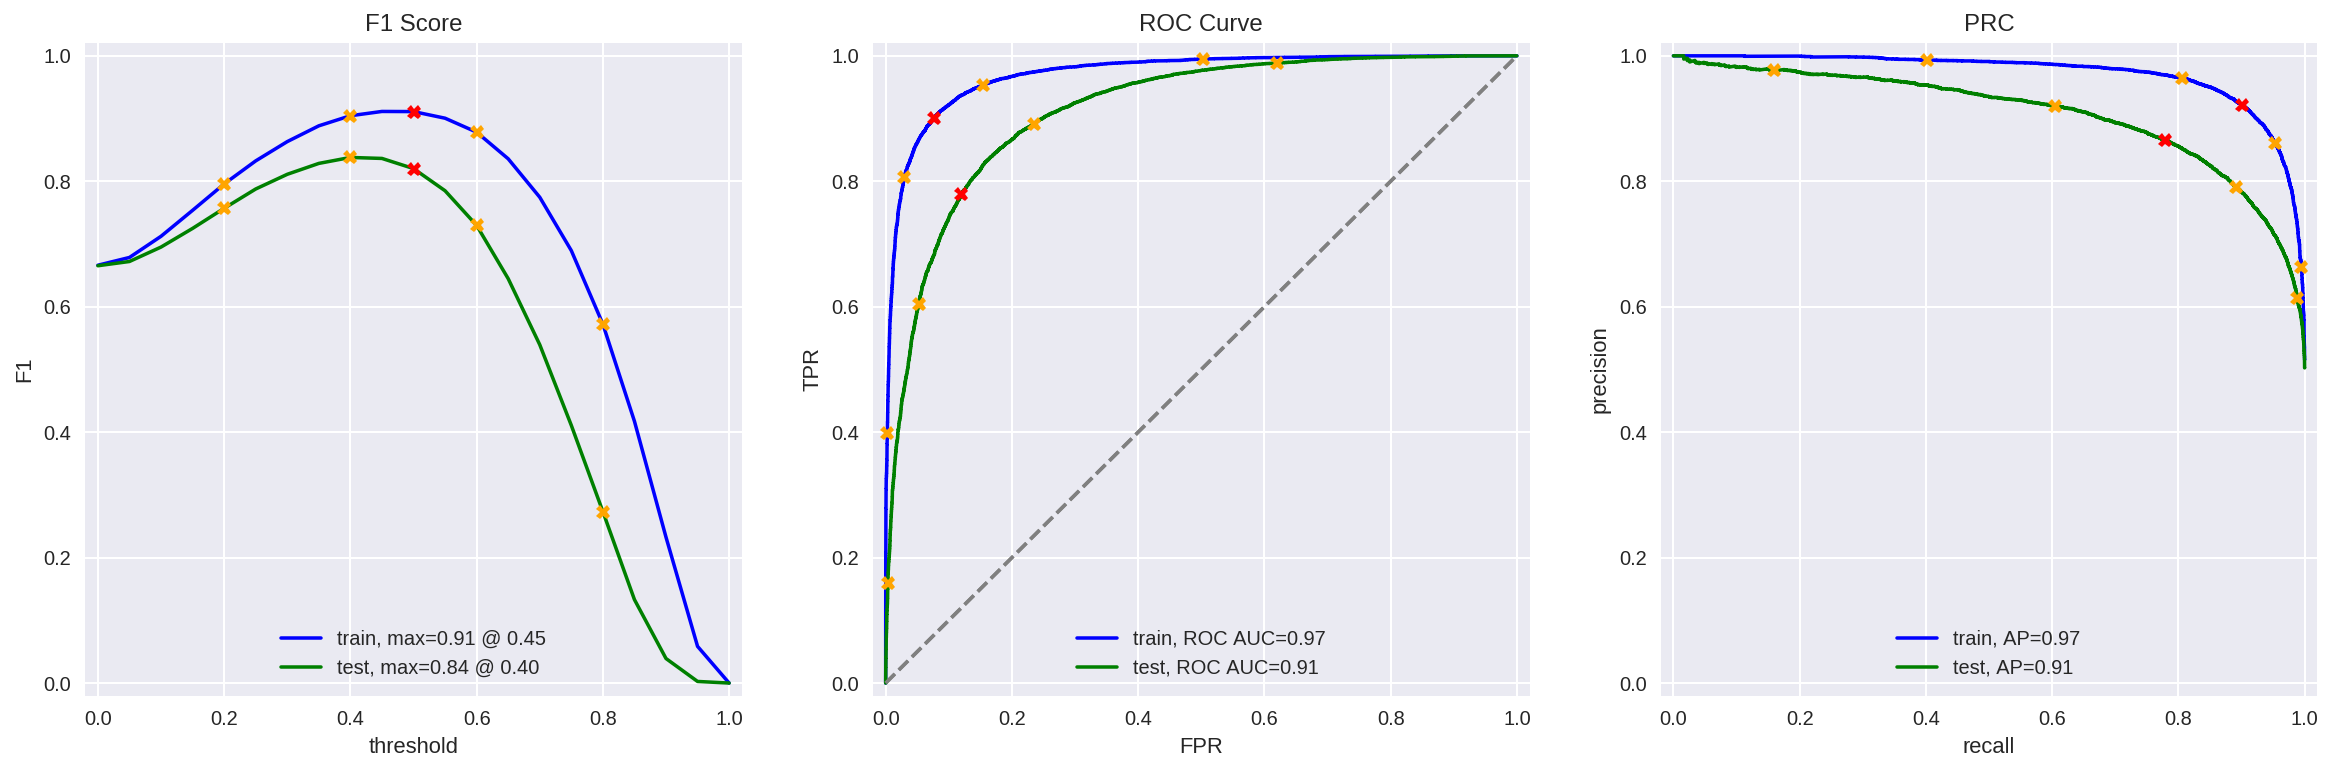

In [29]:
# evaluate naïve bayes model
evaluate_model(nb_clf, nltk_X_train, y_train, nltk_X_test, y_test)

#### Logistic Regression Classifier with NLTK

In [30]:
%%time
# train logistic regression model
logistic_clf = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf.fit(nltk_X_train, y_train)

CPU times: user 3.76 s, sys: 3.34 s, total: 7.1 s
Wall time: 7.05 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


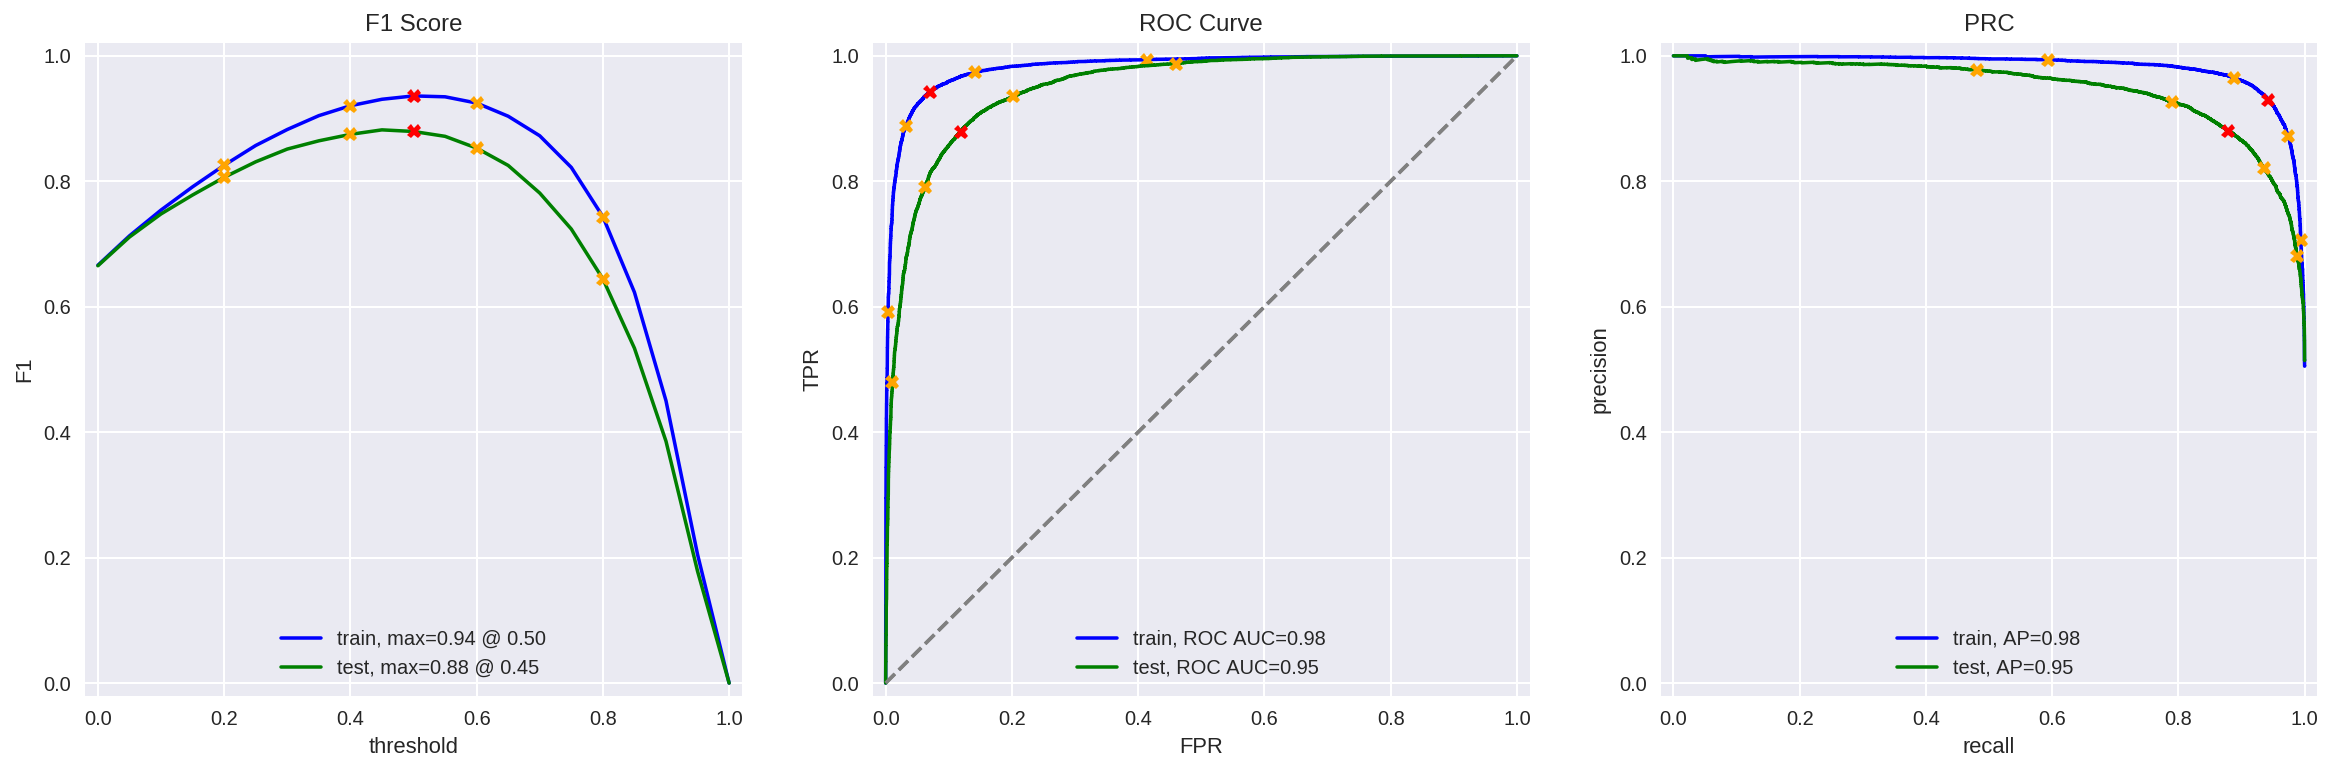

In [31]:
# evaluate logistic regression model
evaluate_model(logistic_clf, nltk_X_train, y_train, nltk_X_test, y_test)

#### LightGBM Classifier with NLTK

In [32]:
%%time
# train lightGBM classifier
lgbm_clf = lgb.LGBMClassifier(random_state=12345)
lgbm_clf.fit(nltk_X_train, y_train)

CPU times: user 1min 58s, sys: 741 ms, total: 1min 59s
Wall time: 2min 1s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


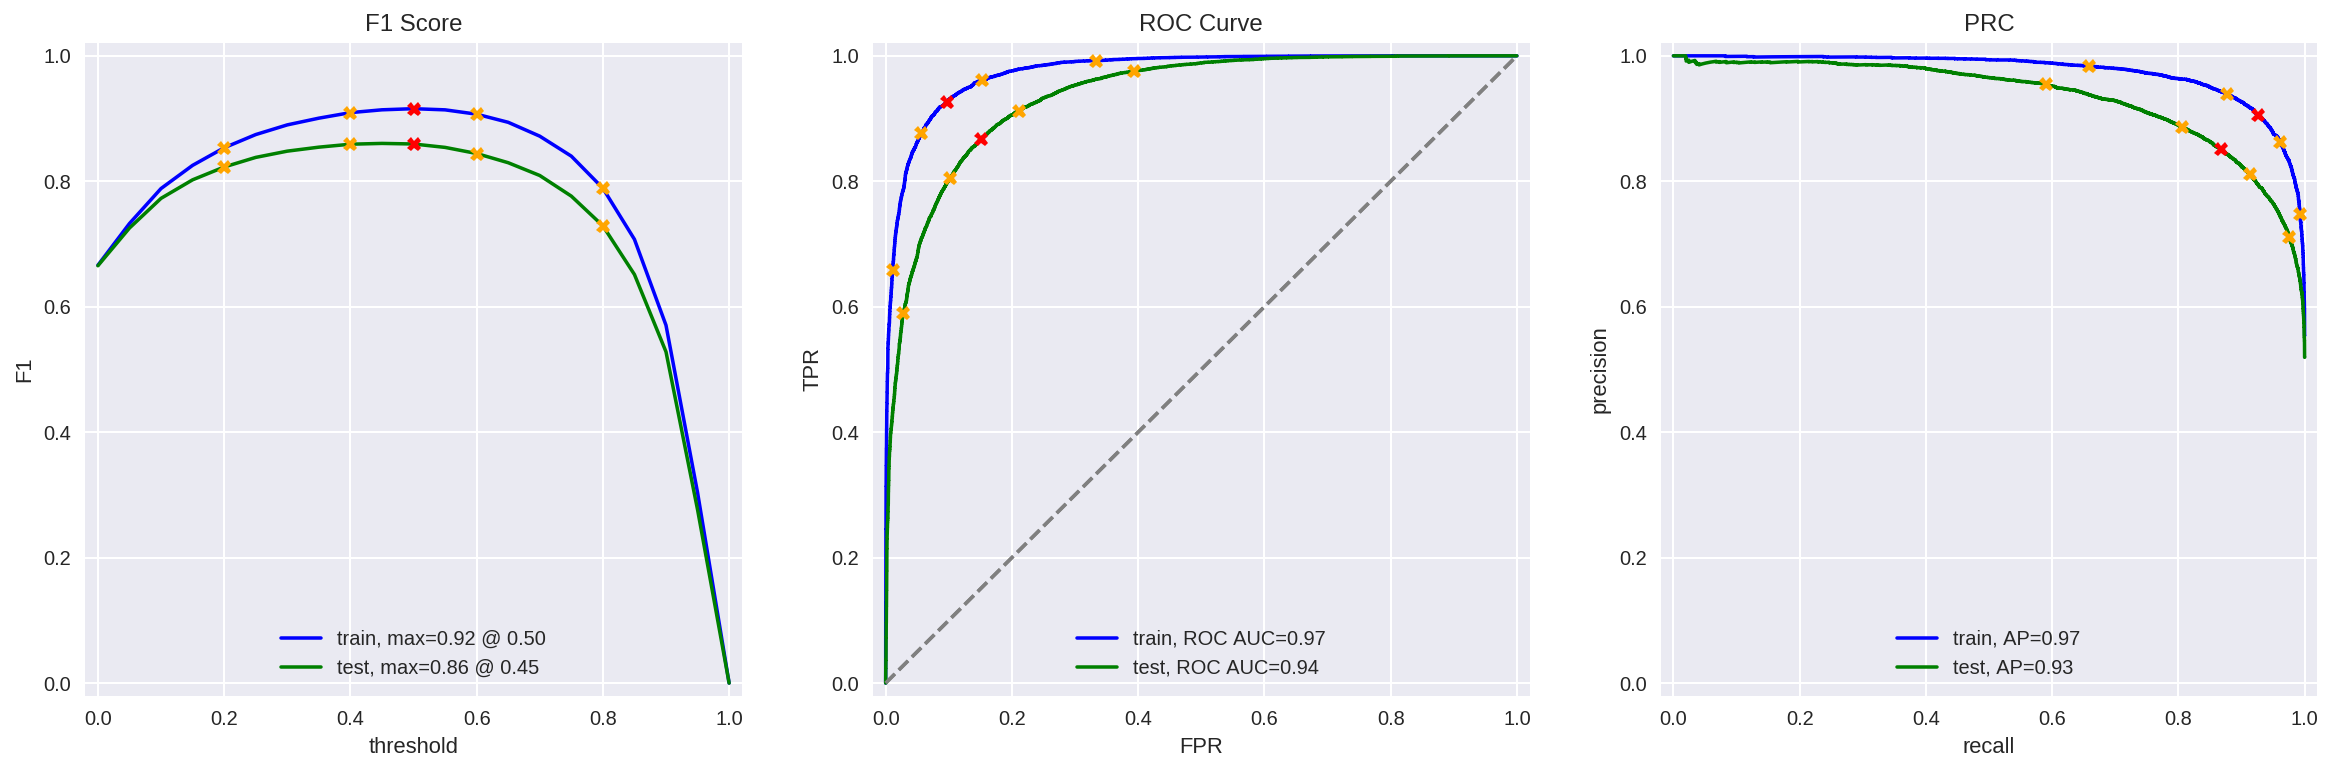

In [33]:
# evaluate lightGBM classifier model
evaluate_model(lgbm_clf, nltk_X_train, y_train, nltk_X_test, y_test)

#### Support Vector Machine (SVM) with NLTK

In [34]:
%%time
# train svc classifier
svm_clf = SVC(random_state=12345, probability=True)
svm_clf.fit(nltk_X_train, y_train)

CPU times: user 46min 2s, sys: 1.79 s, total: 46min 4s
Wall time: 46min 23s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=12345,
    shrinking=True, tol=0.001, verbose=False)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


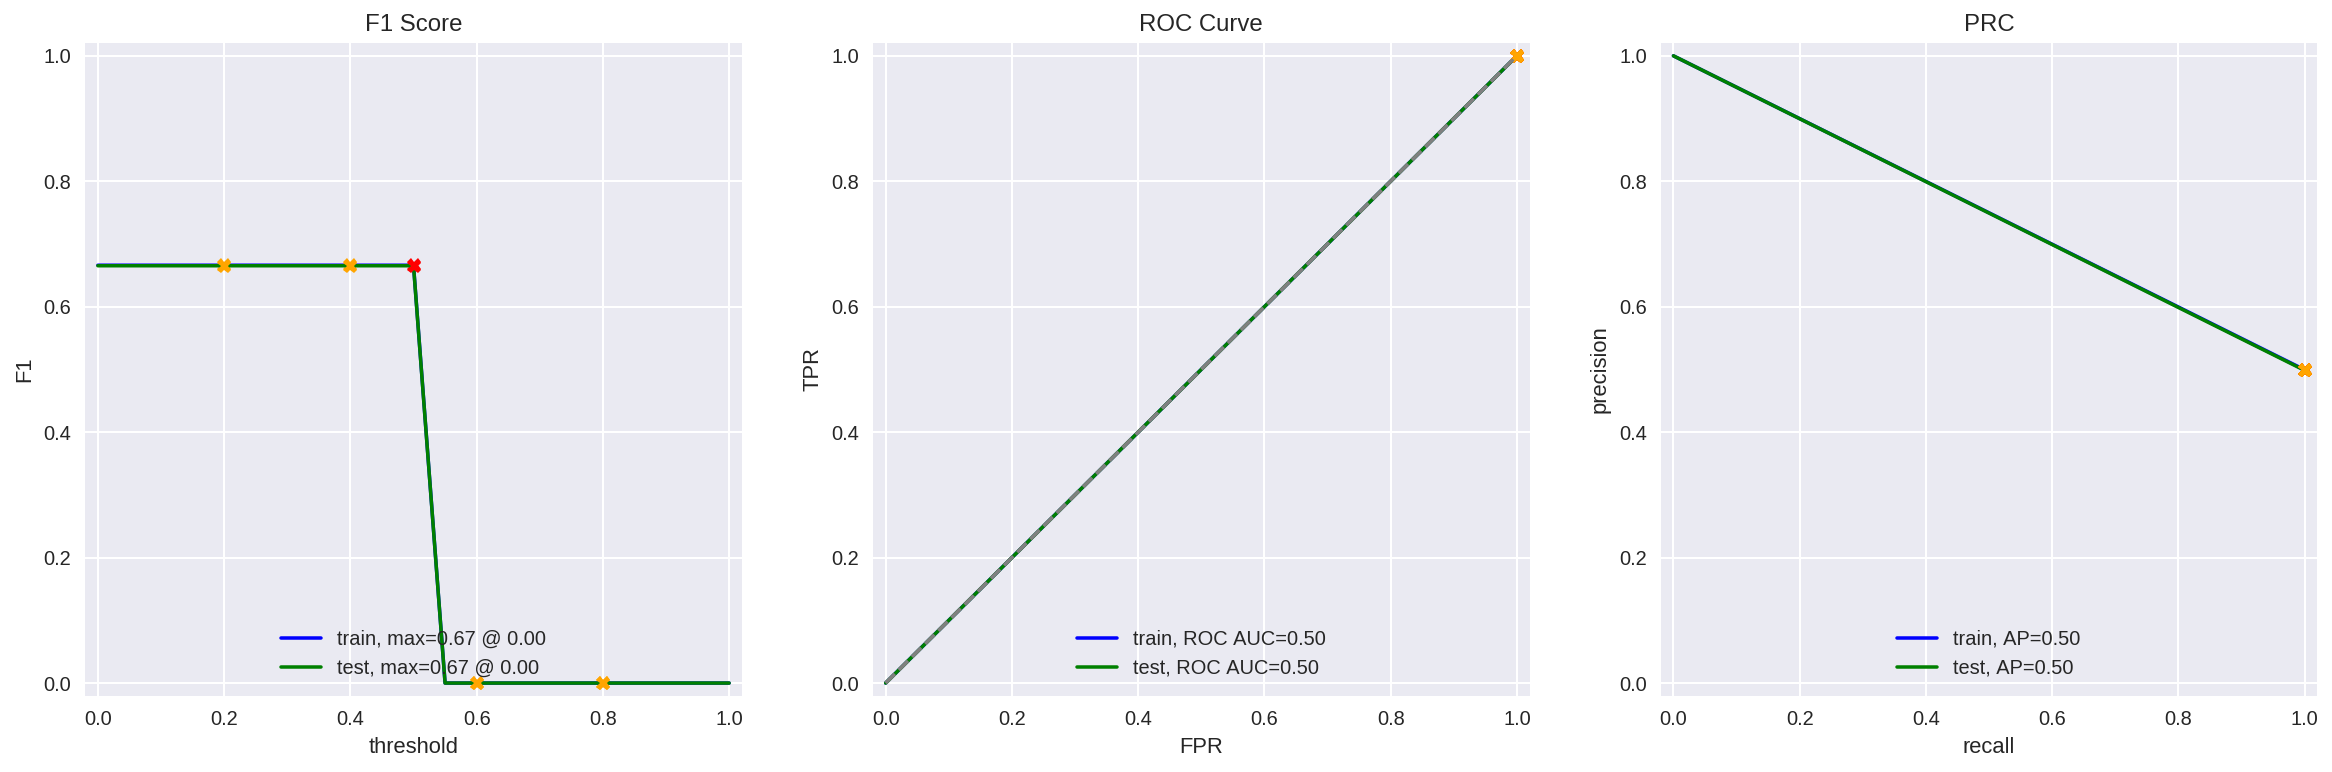

In [35]:
# evaluate support vector machine algorithm
evaluate_model(svm_clf, nltk_X_train, y_train, nltk_X_test, y_test)

### Preprocessing with spaCy and TF-IDF

In [ ]:
# text pre-processing with spaCy
def lemmatize_spacy(text):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

In [ ]:
# apply lemmatization to features with spaCy
df_reviews_train['review_spacy'] = X_train.apply(lemmatize_spacy)
df_reviews_test['review_spacy'] = X_test.apply(lemmatize_spacy)

# recalculate TF-IDF for train and test samples
spacy_X_train = count_tf_idf.fit_transform(df_reviews_train['review_spacy'])
spacy_X_test = count_tf_idf.transform(df_reviews_test['review_spacy'])

#### Naïve Bayes Classifier with spaCy

In [ ]:
%%time
# train naïve bayes classifier
nb_clf_spacy = MultinomialNB()
nb_clf_spacy.fit(spacy_X_train, y_train)

In [ ]:
# evaluate naïve bayes model
evaluate_model(nb_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Logistic Regression Classifier with spaCy

In [ ]:
%%time
# train logistic regression model
logistic_clf_spacy = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf_spacy.fit(spacy_X_train, y_train)

In [ ]:
# evaluate logistic regression model
evaluate_model(logistic_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### LightGBM Classifier with spaCy

In [ ]:
%%time
# train lightGBM classifier
lgbm_clf_spacy = lgb.LGBMClassifier(random_state=12345)
lgbm_clf_spacy.fit(spacy_X_train, y_train)

In [ ]:
# evaluate lightGBM classifier model
evaluate_model(lgbm_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Support Vector Machine (SVM) with spaCy

In [ ]:
%%time
# train svc classifier
svm_clf_spacy = SVC(random_state=12345, probability=True)
svm_clf_spacy.fit(spacy_X_train, y_train)

In [ ]:
# evaluate support vector machine algorithm
evaluate_model(svm_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

###  Preprocessing with BERT

We use 100 random elements from the set as the maximum sample size since computing BERT embeddings takes long on the CPU.

In [ ]:
# maximum sample size
max_sample_size = 100

In [ ]:
# preprocessing text with BERT's tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# function to preprocess for BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size = 25, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = max_sample_size #texts.shape[0]

    # text to padded ids of tokens along with their attention masks
    for input_text in texts.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # create attention_mask_batch
        attention_mask_batch = torch.LongTensor(
            attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
%%time
X_BERT_train = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='None')
y_BERT_train = df_reviews_train.iloc[:max_sample_size]['pos']

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(X_BERT_train.shape)
print(y_BERT_train.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_BERT.npz', X_BERT_train=X_BERT_train, X_BERT_test=X_BERT_test)

# and load...
with np.load('features_BERT.npz') as data:
    X_BERT_train = data['X_BERT_train']
    X_BERT_test = data['X_BERT_test']

#### Naïve Bayes Classifier with BERT

In [ ]:
%%time
# train naïve bayes classifier
nb_clf_BERT = MultinomialNB()
nb_clf_BERT.fit(X_BERT_train, y_BERT_train)

In [ ]:
# evaluate naïve bayes model
evaluate_model(nb_clf_BERT, X_BERT_train, y_train, X_BERT_test, y_test)

#### Logistic Regression Classifier with BERT

In [ ]:
%%time
# train logistic regression model
logistic_clf_BERT = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf_BERT.fit(X_BERT_train, y_BERT_train)

In [ ]:
# evaluate logistic regression model
evaluate_model(logistic_clf_BERT, X_BERT_train, y_train, X_BERT_test, y_test)

#### LightGBM Classifier with BERT

In [ ]:
%%time
# train lightGBM classifier
lgbm_clf_BERT = lgb.LGBMClassifier(random_state=12345)
lgbm_clf_BERT.fit(X_BERT_train, y_BERT_train)

In [ ]:
# evaluate lightGBM classifier model
evaluate_model(lgbm_clf_BERT, X_BERT_train, y_train, X_BERT_test, y_test)

#### Support Vector Machine (SVM) with BERT

In [ ]:
%%time
# train svc classifier
svm_clf_BERT = SVC(random_state=12345, probability=True)
svm_clf_BERT.fit(X_BERT_train, y_BERT_train)

In [ ]:
# evaluate support vector machine algorithm
evaluate_model(svm_clf_BERT, X_BERT_train, y_train, X_BERT_test, y_test)

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = # <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [740]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3

In [741]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.40:  i did not simply like it  not my kind of movie 
0.17:  well  i was bored and felt asleep in the middle of the movie 
0.51:  i was really fascinated with the movie
0.31:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.54:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.13:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.86:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In [742]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it  not my kind of movie 
0.32:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.58:  i didn t expect the reboot to be so good  writers really cared about the source material
0.63:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.27:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.85:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9

In [743]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.21:  i didn t expect the reboot to be so good  writers really cared about the source material
0.94:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions